In [122]:
# Install library yang diperlukan (jika belum terinstall)
# Uncomment baris di bawah jika perlu install
# !pip install sastrawi wordcloud

# Import library yang diperlukan
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import time
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Set style untuk visualisasi
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")

print("Library berhasil diimport!")


Library berhasil diimport!


In [123]:
# Load dataset
df = pd.read_csv('sentimendataset.csv')

# Dataset hanya memiliki 1 kolom, kita rename menjadi 'text'
df.columns = ['text']

# Hapus baris yang kosong
df = df.dropna()
df = df[df['text'].str.strip() != '']

print(f"Jumlah data: {len(df)}")
print(f"\nContoh data sebelum preprocessing:")
print(df.head(3))
print(f"\nContoh teks pertama:")
print(df.iloc[0]['text'])


Jumlah data: 1581

Contoh data sebelum preprocessing:
                                                text
0  saya pesan gofood pilih bayar ongkir extra yan...
1  Jek..kalau nyari'in driver jangan lebih dari 1...
2  bisa bisa nya udah pesan go food lalu di cance...

Contoh teks pertama:
saya pesan gofood pilih bayar ongkir extra yang datang 35menit, yg akan datang jam set3. tapi stuck di 21menit tulisannya sampai di jam 3 lewat dari estimasi tiba" cancel otomatis dari aplikasi!!!!!! saya nunggu lama, gda voucher keterlambatan. dicamcel otomatis biar ga ngasih voucher jaminan ya?????? cuma s3 marketing voucher jaminan. datangnya telat!!! saya pesan lagi pakai extra ongkir waktunya malah 50menit!!!! yang mana sama aja sama harga standar!!!!! sangat kecewa!!!! buang" waktu!!!!


In [124]:
# Membuat label sentimen berdasarkan kata kunci
# Catatan: Idealnya label sudah ada di dataset, ini hanya untuk demonstrasi

def create_sentiment_label(text):
    """
    Membuat label sentimen berdasarkan kata kunci.
    Dalam implementasi nyata, label seharusnya sudah ada di dataset.
    """
    text_lower = text.lower()
    
    # Kata kunci positif
    positive_keywords = ['bagus', 'baik', 'puas', 'senang', 'mudah', 'cepat', 'terbantu', 
                         'mantap', 'recommend', 'suka', 'menyenangkan', 'mempermudah',
                         'terima kasih', 'terimakasih', 'helpful', 'enak']
    
    # Kata kunci negatif
    negative_keywords = ['buruk', 'jelek', 'kecewa', 'mengecewakan', 'susah', 'lama', 
                        'error', 'bug', 'masalah', 'tidak', 'gak', 'ga', 'payah',
                        'parah', 'jengkel', 'risih', 'repot', 'mahal', 'telat', 'batal']
    
    pos_count = sum(1 for keyword in positive_keywords if keyword in text_lower)
    neg_count = sum(1 for keyword in negative_keywords if keyword in text_lower)
    
    if neg_count > pos_count:
        return 'negatif'
    elif pos_count > neg_count:
        return 'positif'
    else:
        # Jika seimbang, cek panjang dan konteks
        if len(text) < 50:
            return 'positif'  # Teks pendek cenderung positif
        return 'negatif'  # Default untuk teks panjang yang ambigu

df['sentiment'] = df['text'].apply(create_sentiment_label)

print("Distribusi label sentimen:")
print(df['sentiment'].value_counts())
print(f"\nPersentase:")
print(df['sentiment'].value_counts(normalize=True) * 100)


Distribusi label sentimen:
sentiment
negatif    1443
positif     138
Name: count, dtype: int64

Persentase:
sentiment
negatif    91.271347
positif     8.728653
Name: proportion, dtype: float64


In [125]:
# Undersampling untuk menyeimbangkan data
# Ambil jumlah yang sama dari kedua kelas (sesuai dengan kelas minoritas)
print("Sebelum undersampling:")
print(f"Total data: {len(df)}")
print(f"Negatif: {len(df[df['sentiment'] == 'negatif'])}")
print(f"Positif: {len(df[df['sentiment'] == 'positif'])}")

# Ambil semua data positif
df_positif = df[df['sentiment'] == 'positif'].copy()

# Ambil sampel random dari negatif dengan jumlah yang sama dengan positif
n_positif = len(df_positif)
df_negatif = df[df['sentiment'] == 'negatif'].sample(n=n_positif, random_state=42)

# Gabungkan kembali
df_balanced = pd.concat([df_positif, df_negatif], ignore_index=True)

# Acak urutan data
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nSetelah undersampling:")
print(f"Total data: {len(df_balanced)}")
print(f"Negatif: {len(df_balanced[df_balanced['sentiment'] == 'negatif'])}")
print(f"Positif: {len(df_balanced[df_balanced['sentiment'] == 'positif'])}")
print(f"\nPersentase:")
print(df_balanced['sentiment'].value_counts(normalize=True) * 100)

# Ganti df dengan df_balanced
df = df_balanced.copy()

print(f"\n Data sekarang sudah seimbang! Dataset berkurang menjadi {len(df)} sampel (50% positif, 50% negatif).")


Sebelum undersampling:
Total data: 1581
Negatif: 1443
Positif: 138

Setelah undersampling:
Total data: 276
Negatif: 138
Positif: 138

Persentase:
sentiment
positif    50.0
negatif    50.0
Name: proportion, dtype: float64

 Data sekarang sudah seimbang! Dataset berkurang menjadi 276 sampel (50% positif, 50% negatif).


In [126]:
def case_folding(text):
    """Mengubah semua teks menjadi lowercase"""
    return text.lower()

df['text_casefold'] = df['text'].apply(case_folding)

print("Contoh sebelum case folding:")
print(df.iloc[0]['text'][:100])
print("\nContoh setelah case folding:")
print(df.iloc[0]['text_casefold'][:100])


Contoh sebelum case folding:
Alhamdulillah sangat terbantu ada fasilitas GOJEK/GOCAR semoga para driver menjaga penampilan, spd/m

Contoh setelah case folding:
alhamdulillah sangat terbantu ada fasilitas gojek/gocar semoga para driver menjaga penampilan, spd/m


In [127]:
def cleaning(text):
    """
    Membersihkan teks dari:
    - Angka
    - Tanda baca
    - Emoji
    - Karakter khusus
    """
    # Hapus emoji dan karakter unicode
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    
    # Hapus multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Hapus leading/trailing spaces
    text = text.strip()
    
    return text

df['text_cleaned'] = df['text_casefold'].apply(cleaning)

print("Contoh sebelum cleaning:")
print(df.iloc[0]['text_casefold'][:150])
print("\nContoh setelah cleaning:")
print(df.iloc[0]['text_cleaned'][:150])


Contoh sebelum cleaning:
alhamdulillah sangat terbantu ada fasilitas gojek/gocar semoga para driver menjaga penampilan, spd/mobilnya dan bb agar penumpang juga nyaman, senang 

Contoh setelah cleaning:
alhamdulillah sangat terbantu ada fasilitas gojek gocar semoga para driver menjaga penampilan spd mobilnya dan bb agar penumpang juga nyaman senang du


In [128]:
# Inisialisasi Sastrawi StopWord Remover
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

# Tambahan stopword manual
# Alasan: Kata-kata ini spesifik untuk domain aplikasi Gojek dan tidak memberikan 
# informasi sentimen yang signifikan, sehingga lebih baik dihapus
additional_stopwords = [
    'aplikasi', 'gojek', 'gofood', 'goride', 'gocar', 'gosend', 
    'driver', 'pesan', 'order', 'pesanan', 'gopay', 'gopinjam'
]

def remove_stopwords(text):
    """Menghapus stopword menggunakan Sastrawi + stopword manual"""
    # Hapus stopword Sastrawi
    text = stopword.remove(text)
    
    # Hapus stopword tambahan
    words = text.split()
    words = [word for word in words if word not in additional_stopwords]
    
    return ' '.join(words)

df['text_no_stopword'] = df['text_cleaned'].apply(remove_stopwords)

print("Contoh sebelum stopword removal:")
print(df.iloc[0]['text_cleaned'][:150])
print("\nContoh setelah stopword removal:")
print(df.iloc[0]['text_no_stopword'][:150])


Contoh sebelum stopword removal:
alhamdulillah sangat terbantu ada fasilitas gojek gocar semoga para driver menjaga penampilan spd mobilnya dan bb agar penumpang juga nyaman senang du

Contoh setelah stopword removal:
alhamdulillah sangat terbantu fasilitas semoga menjaga penampilan spd mobilnya bb penumpang nyaman senang duduk belakang nya


In [ ]:
# Inisialisasi Sastrawi Stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming_text(text):
    """Melakukan stemming menggunakan Sastrawi"""
    return stemmer.stem(text)

df['text_stemmed'] = df['text_no_stopword'].apply(stemming_text)

print("Contoh sebelum stemming:")
print(df.iloc[0]['text_no_stopword'][:150])
print("\nContoh setelah stemming:")
print(df.iloc[0]['text_stemmed'][:150])


In [ ]:
# Tampilkan contoh before vs after untuk beberapa sampel
print("="*80)
print("CONTOH BEFORE vs AFTER PREPROCESSING")
print("="*80)

sample_indices = [0, 1, 2, 5, 10]

for idx in sample_indices:
    if idx < len(df):
        print(f"\n{'='*80}")
        print(f"SAMPLE {idx + 1}:")
        print(f"{'='*80}")
        print(f"\nBEFORE (Original):")
        print(f"{df.iloc[idx]['text'][:200]}...")
        print(f"\nAFTER (Preprocessed):")
        print(f"{df.iloc[idx]['text_stemmed'][:200]}...")
        print(f"\nLabel: {df.iloc[idx]['sentiment']}")
        print(f"\n{'='*80}\n")


CONTOH BEFORE vs AFTER PREPROCESSING

SAMPLE 1:

BEFORE (Original):
Alhamdulillah sangat terbantu ada fasilitas GOJEK/GOCAR semoga para driver menjaga penampilan, spd/mobilnya dan BB agar penumpang juga nyaman, senang duduk di belakang nya...

AFTER (Preprocessed):
alhamdulillah sangat bantu fasilitas moga jaga tampil spd mobil bb tumpang nyaman senang duduk belakang nya...

Label: positif



SAMPLE 2:

BEFORE (Original):
Cepat dan kenyamanan dalam berkendaraan ....

AFTER (Preprocessed):
cepat nyaman kendara...

Label: positif



SAMPLE 3:

BEFORE (Original):
sebenernya bagus ya aplikasi ini, tapi kenapa saya memberikan bintang 2, di hal makanan, ketika memesan makanan dan ngga bisa di batalkan, padahal saya sudah nunggu sangat lama hanya karena belum dapa...

AFTER (Preprocessed):
sebenernya bagus beri bintang hal makan mes makan ngga di batal padahal sudah nunggu sangat lama dapat saya butuh segera makan tapi karena ngga terlalu banyak lebih batas waktu estimasi makan belum ha...

L

In [ ]:
# Persiapan data untuk TF-IDF
X = df['text_stemmed'].values
y = df['sentiment'].values

# TF-IDF Vectorization
# Parameter:
# - max_features: batasi jumlah fitur (vocabulary) untuk mengurangi dimensi
# - ngram_range: gunakan unigram dan bigram untuk menangkap konteks
# - min_df: abaikan kata yang muncul kurang dari 2 dokumen
# - max_df: abaikan kata yang muncul di lebih dari 80% dokumen (stopword umum)
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

X_tfidf = vectorizer.fit_transform(X)

print(f"Shape data setelah TF-IDF: {X_tfidf.shape}")
print(f"Jumlah fitur (vocabulary): {len(vectorizer.get_feature_names_out())}")
print(f"\nContoh fitur (kata-kata penting):")
print(vectorizer.get_feature_names_out()[:20])


Shape data setelah TF-IDF: (276, 1020)
Jumlah fitur (vocabulary): 1020

Contoh fitur (kata-kata penting):
['abis' 'ada' 'ada kendala' 'ada yg' 'adalah' 'admin' 'adu' 'aja'
 'aja gak' 'aja kurang' 'akal' 'akan' 'akan ganti' 'akhir' 'akhir akhir'
 'aktif' 'aktifitas' 'aktivitas' 'aku' 'aku mau']


In [ ]:
# Split data 80:20
# Simpan indeks untuk tracking data asli
# X_tfidf adalah sparse matrix, gunakan shape[0] untuk mendapatkan jumlah baris
indices = np.arange(X_tfidf.shape[0])
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X_tfidf, y, indices,
    test_size=0.2, 
    random_state=42,
    stratify=y  # Mempertahankan proporsi kelas
)

print(f"Data training: {X_train.shape[0]} sampel")
print(f"Data testing: {X_test.shape[0]} sampel")
print(f"\nDistribusi kelas di training:")
print(pd.Series(y_train).value_counts())
print(f"\nDistribusi kelas di testing:")
print(pd.Series(y_test).value_counts())


Data training: 220 sampel
Data testing: 56 sampel

Distribusi kelas di training:
negatif    110
positif    110
Name: count, dtype: int64

Distribusi kelas di testing:
negatif    28
positif    28
Name: count, dtype: int64


In [ ]:
# SVM Linear
# Catatan: Data sudah seimbang melalui undersampling, jadi tidak perlu class_weight
print("Training SVM Linear...")
start_time = time.time()

svm_linear = SVC(kernel='linear', random_state=42, probability=True)
svm_linear.fit(X_train, y_train)

train_time_linear = time.time() - start_time

# Prediksi
y_pred_linear = svm_linear.predict(X_test)
accuracy_linear = accuracy_score(y_test, y_pred_linear)

print(f"\nSVM Linear - Waktu training: {train_time_linear:.4f} detik")
print(f"SVM Linear - Akurasi: {accuracy_linear:.4f} ({accuracy_linear*100:.2f}%)")


Training SVM Linear...

SVM Linear - Waktu training: 0.0103 detik
SVM Linear - Akurasi: 0.8929 (89.29%)


In [ ]:
# SVM RBF
# Catatan: Data sudah seimbang melalui undersampling, jadi tidak perlu class_weight
print("Training SVM RBF...")
start_time = time.time()

svm_rbf = SVC(kernel='rbf', random_state=42, probability=True)
svm_rbf.fit(X_train, y_train)

train_time_rbf = time.time() - start_time

# Prediksi
y_pred_rbf = svm_rbf.predict(X_test)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)

print(f"\nSVM RBF - Waktu training: {train_time_rbf:.4f} detik")
print(f"SVM RBF - Akurasi: {accuracy_rbf:.4f} ({accuracy_rbf*100:.2f}%)")


Training SVM RBF...

SVM RBF - Waktu training: 0.0135 detik
SVM RBF - Akurasi: 0.8571 (85.71%)


PERBANDINGAN HASIL:
     Model  Akurasi  Waktu Training (detik)
SVM Linear 0.892857                0.010328
   SVM RBF 0.857143                0.013529


C:\Users\HD\AppData\Local\Temp\ipykernel_22084\314278500.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(comparison['Model'], fontsize=11, rotation=0)
C:\Users\HD\AppData\Local\Temp\ipykernel_22084\314278500.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(comparison['Model'], fontsize=11, rotation=0)


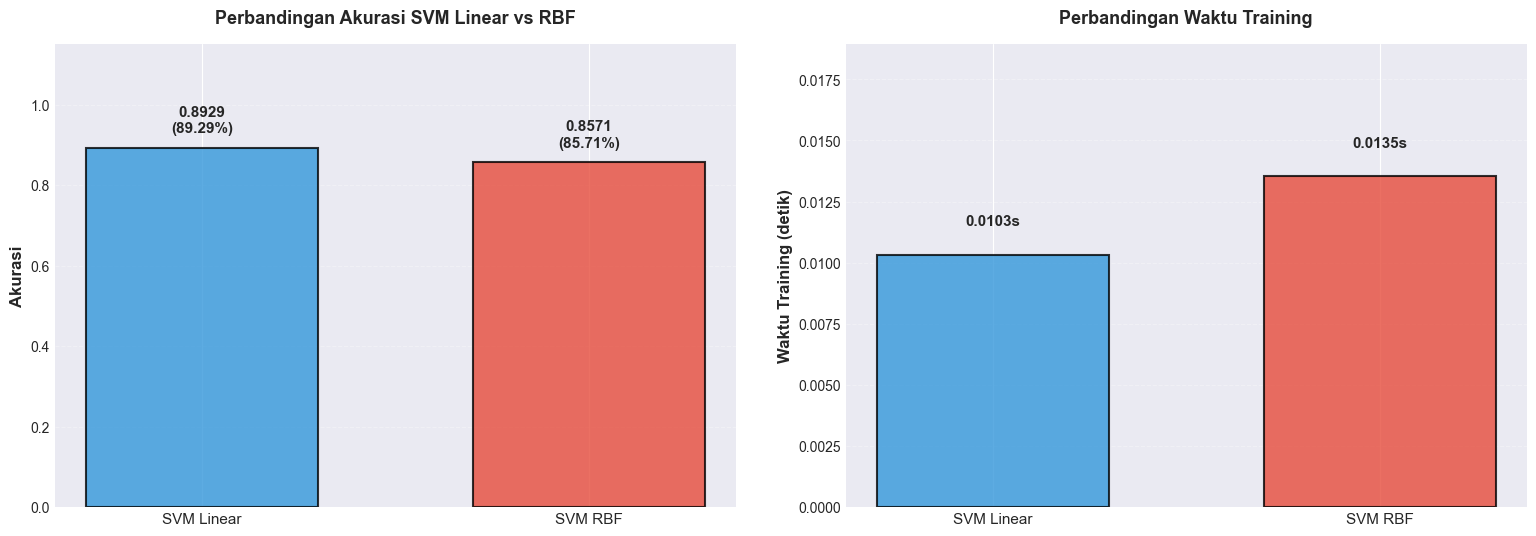

In [ ]:
# Perbandingan hasil
comparison = pd.DataFrame({
    'Model': ['SVM Linear', 'SVM RBF'],
    'Akurasi': [accuracy_linear, accuracy_rbf],
    'Waktu Training (detik)': [train_time_linear, train_time_rbf]
})

print("PERBANDINGAN HASIL:")
print("="*50)
print(comparison.to_string(index=False))
print("="*50)

# Visualisasi perbandingan dengan perbaikan
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Perbandingan akurasi
bars1 = axes[0].bar(comparison['Model'], comparison['Akurasi'], 
                    color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=1.5, width=0.6)
axes[0].set_ylabel('Akurasi', fontsize=12, fontweight='bold')
axes[0].set_title('Perbandingan Akurasi SVM Linear vs RBF', fontsize=13, fontweight='bold', pad=15)
axes[0].set_ylim([0, 1.15])
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_xticklabels(comparison['Model'], fontsize=11, rotation=0)

# Tambahkan nilai di atas bar dengan format persentase
for i, (bar, v) in enumerate(zip(bars1, comparison['Akurasi'])):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.03,
                   f'{v:.4f}\n({v*100:.2f}%)',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')

# Perbandingan waktu
bars2 = axes[1].bar(comparison['Model'], comparison['Waktu Training (detik)'], 
                    color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=1.5, width=0.6)
axes[1].set_ylabel('Waktu Training (detik)', fontsize=12, fontweight='bold')
axes[1].set_title('Perbandingan Waktu Training', fontsize=13, fontweight='bold', pad=15)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].set_xticklabels(comparison['Model'], fontsize=11, rotation=0)

# Tambahkan nilai di atas bar untuk waktu
max_time = comparison['Waktu Training (detik)'].max()
axes[1].set_ylim([0, max_time * 1.4])
for i, (bar, v) in enumerate(zip(bars2, comparison['Waktu Training (detik)'])):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + max_time * 0.08,
                 f'{v:.4f}s',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout(pad=3.0)
plt.show()


In [ ]:
# Menyimpan model dan vectorizer untuk digunakan di app.py
import joblib

# Pilih model terbaik berdasarkan akurasi
best_model = svm_linear if accuracy_linear >= accuracy_rbf else svm_rbf
best_model_name = "SVM Linear" if accuracy_linear >= accuracy_rbf else "SVM RBF"
best_accuracy = accuracy_linear if accuracy_linear >= accuracy_rbf else accuracy_rbf

print(f" Menyimpan model terbaik: {best_model_name}")
print(f"   Akurasi: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# Verifikasi bahwa model memiliki probability=True
if not hasattr(best_model, 'probability') or not best_model.probability:
    print("\n⚠️ PERINGATAN: Model tidak memiliki probability=True!")
    print("   Model akan di-re-train dengan probability=True...")
    
    # Re-train model dengan probability=True
    if best_model_name == "SVM Linear":
        best_model = SVC(kernel='linear', random_state=42, probability=True)
    else:
        best_model = SVC(kernel='rbf', random_state=42, probability=True)
    
    best_model.fit(X_train, y_train)
    
    # Re-evaluasi
    y_pred_re_eval = best_model.predict(X_test)
    accuracy_re_eval = accuracy_score(y_test, y_pred_re_eval)
    print(f"   ✅ Model re-trained dengan probability=True")
    print(f"   📊 Akurasi setelah re-train: {accuracy_re_eval:.4f} ({accuracy_re_eval*100:.2f}%)")
else:
    print(f"   ✅ Model sudah memiliki probability=True: {best_model.probability}")

# Simpan vectorizer dan model
# SEMUA PROSES DILAKUKAN DI NOTEBOOK INI - TIDAK PERLU FILE TERPISAH
print("\n💾 Menyimpan vectorizer dan model...")
joblib.dump(vectorizer, 'vectorizer.pkl')
joblib.dump(best_model, 'svm_model.pkl')

print("\n Model dan vectorizer berhasil disimpan!")
print("File yang dibuat:")
print("   - vectorizer.pkl")
print("   - svm_model.pkl")
print(f"\n Sekarang Anda bisa menjalankan aplikasi Streamlit dengan:")
print("   streamlit run app.py")
print(f"\n Model yang digunakan: {best_model_name} (Akurasi: {best_accuracy*100:.2f}%)")


 Menyimpan model terbaik: SVM Linear
   Akurasi: 0.8929 (89.29%)

 Model dan vectorizer berhasil disimpan!
File yang dibuat:
   - vectorizer.pkl
   - svm_model.pkl

 Sekarang Anda bisa menjalankan aplikasi Streamlit dengan:
   streamlit run app.py

 Model yang digunakan: SVM Linear (Akurasi: 89.29%)


### 📌 Catatan Penting

**Semua proses dilakukan di notebook ini!**

- ✅ Training model dengan `probability=True`
- ✅ Verifikasi model memiliki `probability=True`
- ✅ Auto re-train jika model tidak memiliki `probability=True`
- ✅ Menyimpan model dan vectorizer

**TIDAK PERLU menjalankan script terpisah:**
- ❌ `fix_model.py` - TIDAK PERLU
- ❌ `train_and_save_model.py` - TIDAK PERLU

**Notebook ini adalah PATOKAN UTAMA untuk semua proses!**


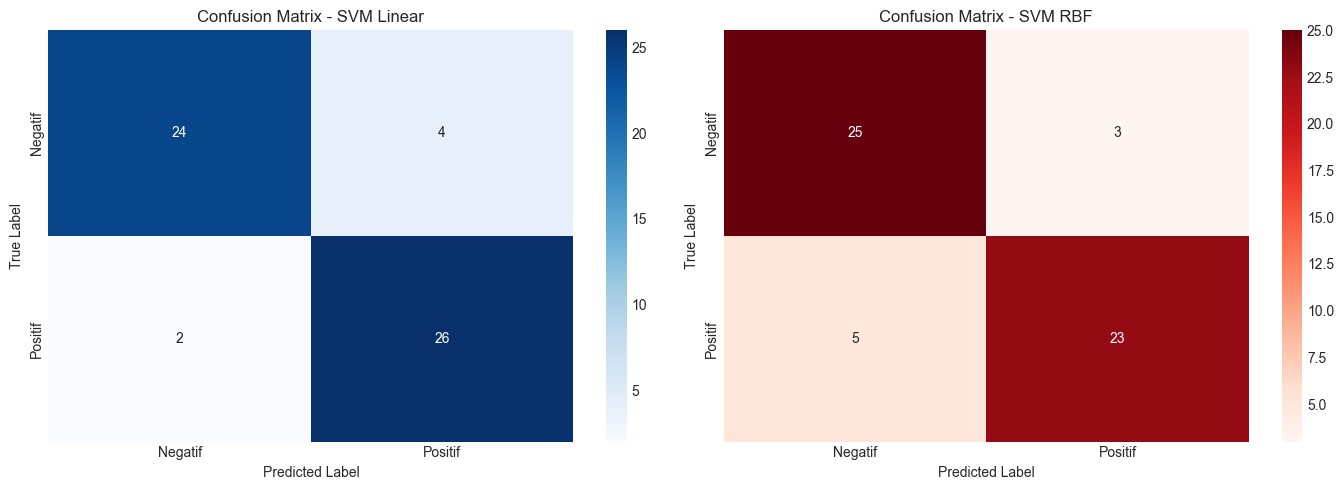


Confusion Matrix SVM Linear:
[[24  4]
 [ 2 26]]

Confusion Matrix SVM RBF:
[[25  3]
 [ 5 23]]


In [ ]:
# Confusion Matrix untuk kedua model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SVM Linear
cm_linear = confusion_matrix(y_test, y_pred_linear)
sns.heatmap(cm_linear, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
axes[0].set_title('Confusion Matrix - SVM Linear')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# SVM RBF
cm_rbf = confusion_matrix(y_test, y_pred_rbf)
sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
axes[1].set_title('Confusion Matrix - SVM RBF')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print("\nConfusion Matrix SVM Linear:")
print(cm_linear)
print("\nConfusion Matrix SVM RBF:")
print(cm_rbf)


In [ ]:
print("="*60)
print("CLASSIFICATION REPORT - SVM LINEAR")
print("="*60)
print(classification_report(y_test, y_pred_linear, target_names=['Negatif', 'Positif']))

print("\n" + "="*60)
print("CLASSIFICATION REPORT - SVM RBF")
print("="*60)
print(classification_report(y_test, y_pred_rbf, target_names=['Negatif', 'Positif']))


CLASSIFICATION REPORT - SVM LINEAR
              precision    recall  f1-score   support

     Negatif       0.92      0.86      0.89        28
     Positif       0.87      0.93      0.90        28

    accuracy                           0.89        56
   macro avg       0.89      0.89      0.89        56
weighted avg       0.89      0.89      0.89        56


CLASSIFICATION REPORT - SVM RBF
              precision    recall  f1-score   support

     Negatif       0.83      0.89      0.86        28
     Positif       0.88      0.82      0.85        28

    accuracy                           0.86        56
   macro avg       0.86      0.86      0.86        56
weighted avg       0.86      0.86      0.86        56



In [ ]:
# Ambil contoh kalimat yang salah prediksi
# Gunakan model terbaik (yang akurasi lebih tinggi)
best_model = svm_linear if accuracy_linear >= accuracy_rbf else svm_rbf
best_pred = y_pred_linear if accuracy_linear >= accuracy_rbf else y_pred_rbf
model_name = "SVM Linear" if accuracy_linear >= accuracy_rbf else "SVM RBF"

# Cari indeks yang salah prediksi
wrong_indices = np.where(y_test != best_pred)[0]

print(f"Total salah prediksi: {len(wrong_indices)} dari {len(y_test)} sampel")
print(f"Menggunakan model: {model_name}\n")

# Tampilkan beberapa contoh
print("="*80)
print("CONTOH KALIMAT YANG SALAH PREDIKSI")
print("="*80)

for i, wrong_idx in enumerate(wrong_indices[:10]):  # Tampilkan 10 contoh pertama
    original_idx = test_idx[wrong_idx]
    
    print(f"\nContoh {i+1}:")
    print(f"Teks asli: {df.iloc[original_idx]['text'][:200]}...")
    print(f"Teks preprocessed: {df.iloc[original_idx]['text_stemmed'][:200]}...")
    print(f"Label sebenarnya: {y_test[wrong_idx]}")
    print(f"Label prediksi: {best_pred[wrong_idx]}")
    print("-"*80)


Total salah prediksi: 6 dari 56 sampel
Menggunakan model: SVM Linear

CONTOH KALIMAT YANG SALAH PREDIKSI

Contoh 1:
Teks asli: buruk drivernya nolak Mulu kalau hujan hhhhh,tolong dong drivernya suruh komplit fasilitas seperti jas hujan 2 tidak bisa buat aplikasi pendukung banget.walaupun bukan musik hujan tolong bawa terus ja...
Teks preprocessed: buruk drivernya nolak mulu kalau hujan hhhhh dong drivernya suruh komplit fasilitas jas hujan bisa buat dukung banget walaupun bukan musik hujan bawa terus jas hujan...
Label sebenarnya: negatif
Label prediksi: positif
--------------------------------------------------------------------------------

Contoh 2:
Teks asli: perhitungan perfoma kurang akurat kita sudah online 14hari tp masih stuck di 8hari, jam online pun sama kadang sudah full time narok tp masih stuck ga nambah. ini sangat mengurangi potensi orderan mas...
Teks preprocessed: hitung perfoma kurang akurat online hari tp stuck hari jam online sama kadang full time narok tp stuck ga

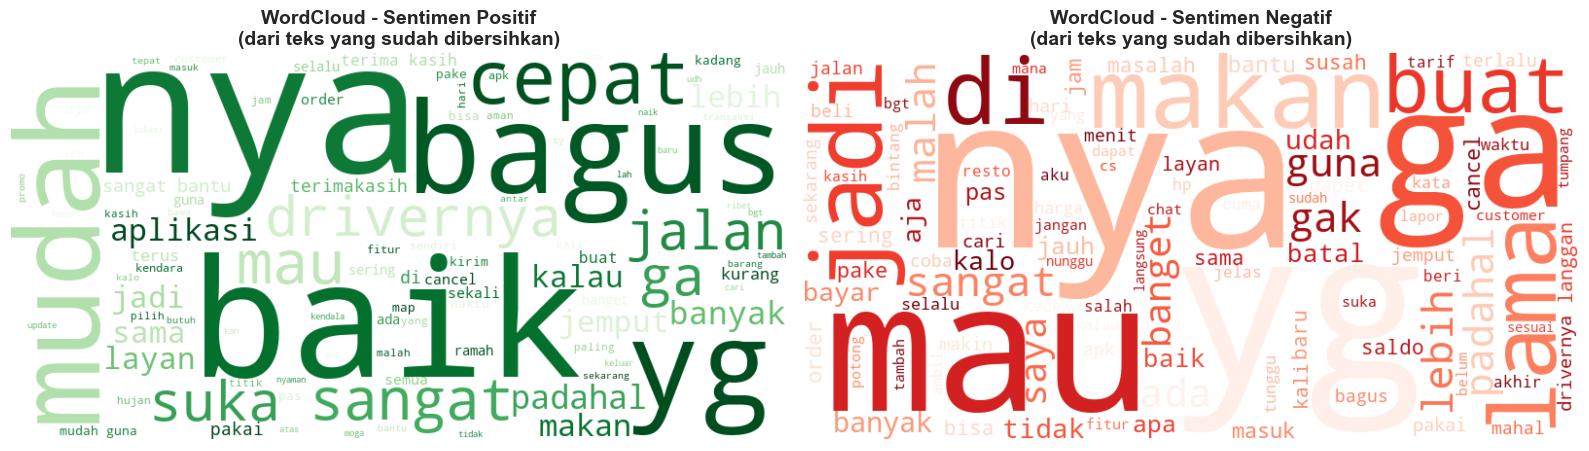

In [ ]:
# Pisahkan teks berdasarkan sentimen (dari data yang sudah dibersihkan/preprocessed)
text_positif = ' '.join(df[df['sentiment'] == 'positif']['text_stemmed'].values)
text_negatif = ' '.join(df[df['sentiment'] == 'negatif']['text_stemmed'].values)

# Buat WordCloud untuk sentimen positif
wordcloud_positif = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    max_words=100,
    colormap='Greens'
).generate(text_positif)

# Buat WordCloud untuk sentimen negatif
wordcloud_negatif = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    max_words=100,
    colormap='Reds'
).generate(text_negatif)

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Konversi WordCloud ke array menggunakan to_image() untuk menghindari error kompatibilitas
# Gunakan np.array() langsung dari PIL Image
from PIL import Image
import numpy as np

# Konversi WordCloud ke PIL Image, lalu ke numpy array
img_positif = wordcloud_positif.to_image()
img_negatif = wordcloud_negatif.to_image()

axes[0].imshow(np.array(img_positif), interpolation='bilinear')
axes[0].set_title('WordCloud - Sentimen Positif\n(dari teks yang sudah dibersihkan)', 
                  fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(np.array(img_negatif), interpolation='bilinear')
axes[1].set_title('WordCloud - Sentimen Negatif\n(dari teks yang sudah dibersihkan)', 
                  fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()
